In [118]:
using Pkg
include("/cluster/home/danare/git/Clustering/TSClustering.jl")
cd("/cluster/home/danare/git/Clustering")
Pkg.activate(".")
using .TSClustering
using Distances
using Clustering
using DataFrames
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Dates
using Statistics
using JuMP

  Activating project at `~/git/Clustering`


In [119]:
# config
path = "/cluster/home/danare/git/GENeSYS_MOD.data/Output/output_excel/Timeseries.xlsx"
config = "/cluster/home/danare/git/Clustering/data/config.yml"
K = [6]
W = Dict(
    "Euclidean" => 0,
    #"DTW (10)"  => 10,
);



[11.569616957477264, 12.071262723845573, 8.86290959402742, 6.425161130612797, 6.905171644330642, 9.081114511212128, 11.522482514005715, 11.994065051884016, 8.920454746657802, 6.822125129605276, 6.725296614400726, 9.461522859836974, 11.404171697772789, 11.561565621321414, 9.052838915059644, 6.937440547798083, 6.295835558356377, 9.759639557286038, 11.325346128712523, 11.191862844066987, 9.258630845972585, 6.802461312988381, 5.945297965086245, 10.025939679586672, 11.224894114648652, 10.756472137879632, 9.487227402888804, 6.564101387080981, 5.363259082826887, 10.285144022936999, 11.255196940973693, 10.263277329036253, 9.542851311015257, 6.716916501995146, 4.9548482013446495, 10.498221332395756, 11.362482716178432, 9.872995064540993, 9.504083084786062, 6.7751503963277155, 4.70219194936691, 10.732514177468346, 11.248966347060115, 9.876280033925292, 9.461585014878379, 6.790687656654531, 4.676527564755511, 10.79173708805858, 10.834945829282212, 10.28101839081527, 9.520693637727515, 6.662395530

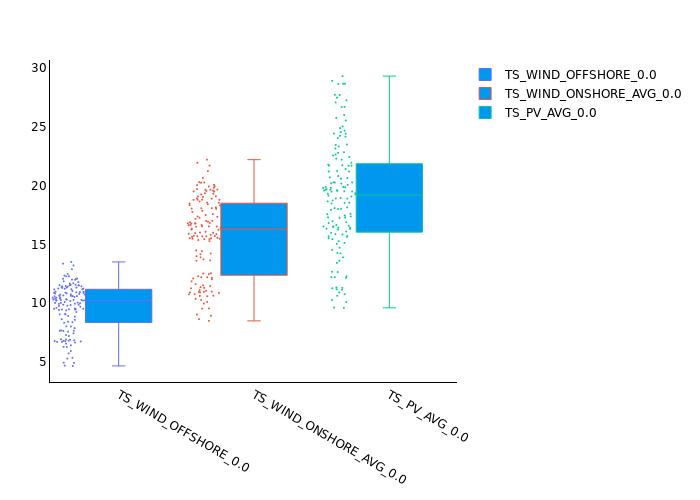

In [120]:
# empty DataFrame
df = DataFrame(Cluster = Float64[], Window = Float64[], Technology =String[], Value = Vector{Vector{}}())

# read in data
config = TSClustering.read_yaml_file(file=config);
data_org = TSClustering.read_data(path=path, config=config);
data_clustering_org = TSClustering.create_clustering_matrix(config=config, CountryData=data_org);
# apply normalization
data = TSClustering.normalize_data(CountryData=data_org, config=config);
data_clustering = TSClustering.create_clustering_matrix(config=config, CountryData=data);

# calculate the distance matrix
for w ∈ values(W)
    D = TSClustering.define_distance(w=w, data_clustering=data_clustering)
    result = hclust(D, linkage=:ward)
    for k ∈ K 
        cl = cutree(result, k=k)
        weights = Dict()
        for i in cl
            weights[i] = get(weights, i, 0) + 1
        end
    
        # bring data in Jump format
        m_cluster_org, mapping_org_data = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);
        cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);
        data_org = TSClustering.read_data(path=path, config=config);
        sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config)

        # sum the region
        z = zeros(length(axes(sc)[3])*length(axes(sc)[4]),1)
        for t ∈ ["TS_WIND_OFFSHORE", "TS_WIND_ONSHORE_AVG", "TS_PV_AVG"] 
            for r ∈ axes(sc)[1]
                m = vcat(sc[r, t, :,:])
                z += reshape(m, length(axes(sc)[3])*length(axes(sc)[4]))
            end
            push!(df, [k, w, t, vec(z)])
        end
    end 
end 

TSClustering.plot_box_technology(df=df)

In [105]:
cl = cutree(result, k=k)
weights = Dict()
for i in cl
    weights[i] = get(weights, i, 0) + 1
end
    
# bring data in Jump format
m_cluster_org, mapping_org_data = TSClustering.calculate_representative(representative=:medoid, data_clustering=data_clustering_org, cl=cl, weights=weights, k=k);
cluster_dict_org = TSClustering.convert_data(k=k, config=config, M=m_cluster_org);
data_org = TSClustering.read_data(path=path, config=config);
sc = TSClustering.scaling(data_org=data_org, scaled_clusters=cluster_dict_org, k=k, weights=weights, config=config)

4-dimensional DenseAxisArray{Float64,4,...} with index sets:
    Dimension 1, ["AT", "BE", "BG", "CH", "CZ", "DE", "DK", "EE", "ES", "FI"  …  "NO", "PL", "PT", "RO", "SE", "SI", "SK", "TR", "UK", "NONEU_Balkan"]
    Dimension 2, ["TS_LOAD", "TS_PV_AVG", "TS_PV_INF", "TS_PV_OPT", "TS_PV_TRA", "TS_WIND_ONSHORE_AVG", "TS_WIND_ONSHORE_INF", "TS_WIND_ONSHORE_OPT", "TS_WIND_OFFSHORE", "TS_WIND_OFFSHORE_SHALLOW", "TS_WIND_OFFSHORE_DEEP", "TS_MOBILITY_PSNG", "TS_HEAT_LOW", "TS_HEAT_HIGH", "TS_HP_AIRSOURCE", "TS_HP_GROUNDSOURCE", "TS_HYDRO_ROR"]
    Dimension 3, 1:6
    Dimension 4, 1:24
And data, a 30×17×6×24 Array{Float64, 4}:
[:, :, 1, 1] =
 0.000102675  0.0  0.0  0.0  0.0  0.140706   …  0.622974  0.77979   0.373059
 0.000110458  0.0  0.0  0.0  0.0  0.262094      0.384412  0.709976  0.301677
 0.000126535  0.0  0.0  0.0  0.0  0.139248      0.385272  0.898902  0.185725
 0.000126329  0.0  0.0  0.0  0.0  0.114284      0.373045  0.909935  0.270308
 0.000107155  0.0  0.0  0.0  0.0  0.138519      0

In [112]:
df_ = DataFrame(A = Vector{Int}(), B = Vector{Vector{}}())

push!(df_, (1, vec(z)))

Row,A,B
,Int64,Vector
1,1,"[19.3016, 18.0822, 15.9883, 10.9235, 10.7591, 15.279, 19.2485, 18.0236, 15.7051, 11.2705 … 16.4157, 13.9018, 12.2094, 18.4714, 22.2001, 19.4939, 16.3349, 13.6064, 12.2122, 18.1433]"


In [114]:
filter(row -> (row.A == 1), df_)[:, :B]

1-element Vector{Vector}:
 [19.3015775581258, 18.08219880292442, 15.98826899327849, 10.92349522359039, 10.759127309961315, 15.27897945443937, 19.24853440088173, 18.023550329551774, 15.705138698728975, 11.27045890223982  …  16.41573066727458, 13.901844487827812, 12.209438245833308, 18.47137250829146, 22.200099963650988, 19.493853995418885, 16.334884234144088, 13.606431167850292, 12.212217441659085, 18.14327177680509]

In [108]:
b = collect(vec(z))

144-element Vector{Float64}:
 19.3015775581258
 18.08219880292442
 15.98826899327849
 10.92349522359039
 10.759127309961315
 15.27897945443937
 19.24853440088173
 18.023550329551774
 15.705138698728975
 11.27045890223982
  ⋮
 13.901844487827812
 12.209438245833308
 18.47137250829146
 22.200099963650988
 19.493853995418885
 16.334884234144088
 13.606431167850292
 12.212217441659085
 18.14327177680509

In [124]:
x = 0
for i in 1:2
    global x
    x += i
end
x

3